<h3>Now, lets classify the processed movie reviews.</h3>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('IMDB_reviews_processed_uncased.csv')
df.head()

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive


<h1>1) Assigning numeric labels to sentiment classes</h1>

In [3]:
def sent_to_int(sent):
  if sent == "negative":
    return 0
  else:
    return 1

df['sentiment'] = df['sentiment'].apply(sent_to_int)
df.head(2)

,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production film technique una...,1


In [4]:
!nvidia-smi

Sat Jul 18 12:45:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<h1>2) Installing requirements</h1>

In [5]:
!pip install -q -U watermark
!pip install -qq transformers

     |████████████████████████████████| 778kB 7.1MB/s 
     |████████████████████████████████| 1.1MB 39.0MB/s 
     |████████████████████████████████| 3.0MB 40.6MB/s 
     |████████████████████████████████| 890kB 38.9MB/s 


In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.5.1+cu101
transformers 3.0.2


<h1>3) Using installed libraries</h1>

In [7]:
# Ignore warnings
import logging
logging.basicConfig(level=logging.ERROR)

In [8]:
# Importing Hugging Face transformers library
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

#Loading BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [10]:
# Experimenting on a single sample
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


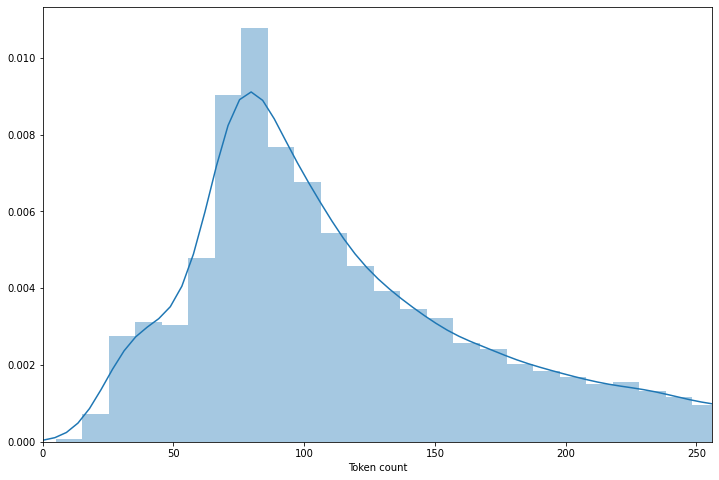

In [11]:
# Looking at distribution of review length (after tokenizing in BERT's format)
import seaborn as sns

token_lens = []

for txt in df.review:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

plt.figure(figsize=(12,8))
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

<h1>4) Using custom Dataset & DataLoader class</h1>

In [13]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [12]:
# Choosing maximum sequence length. Any sentence with lesser length will be padded.
MAX_LEN = 224

In [14]:
class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [15]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [16]:
df_train.head(2)

,review,sentiment
39087,keep ask many fight scream match swear general...,0
30893,not watch entire movie could not watch entire ...,0


In [17]:
print("Train size : {}".format(df_train.shape[0]))
print("Validation size : {}".format(df_val.shape[0]))
print("Test size : {}".format(df_test.shape[0]))

Train size : 40000
Validation size : 5000
Test size : 5000


In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MovieReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [19]:
# Creating train, validation & test dataloaders
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [21]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 224])
torch.Size([8, 224])
torch.Size([8])


In [22]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [23]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [24]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [25]:
bert_model.config.hidden_size

768

In [26]:
pooled_output.shape

torch.Size([1, 768])

<h1>5) Creating custom classifier class</h1>

In [27]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [28]:
class_names = [0,1]

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [29]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 224])
torch.Size([8, 224])


In [30]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5336, 0.4664],
        [0.5571, 0.4429],
        [0.5141, 0.4859],
        [0.5003, 0.4997],
        [0.5394, 0.4606],
        [0.5218, 0.4782],
        [0.5562, 0.4438],
        [0.4938, 0.5062]], device='cuda:0', grad_fn=<SoftmaxBackward>)

<h1>6) Setting model hyperparameters</h1>

In [31]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

<h1>7) Training the model</h1>

In [32]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import time

In [35]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  st = time.time()
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )
  
  print(f'Train loss : {train_loss} Train accuracy : {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )
  
  en = time.time()
  print(f'Val   loss : {val_loss} Val   accuracy : {val_acc}')
  print("Time taken for epoch-{} is {} mins".format(epoch+1, (en-st)/60))  
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss : 0.42841285066753626 Train accuracy : 0.8317
Val   loss : 0.4111071914792061 Val   accuracy : 0.8622000000000001
Time taken for epoch-1 is 58.482023147741955 mins

Epoch 2/10
----------
Train loss : 0.37188280913308264 Train accuracy : 0.882225
Val   loss : 0.4100860968470573 Val   accuracy : 0.8416
Time taken for epoch-2 is 58.353056422869365 mins

Epoch 3/10
----------
Train loss : 0.3316008949711919 Train accuracy : 0.8984000000000001
Val   loss : 0.3875881351470947 Val   accuracy : 0.8766
Time taken for epoch-3 is 58.35034976402918 mins

Epoch 4/10
----------
Train loss : 0.30054327943250536 Train accuracy : 0.919475
Val   loss : 0.3964500271439552 Val   accuracy : 0.8874000000000001
Time taken for epoch-4 is 58.121392265955606 mins

Epoch 5/10
----------
Train loss : 0.27258437638506294 Train accuracy : 0.9307000000000001
Val   loss : 0.4379416446983814 Val   accuracy : 0.8908
Time taken for epoch-5 is 58.49746271769206 mins

Epoch 6/10
----------

<h1>8) Plotting model performance</h1>

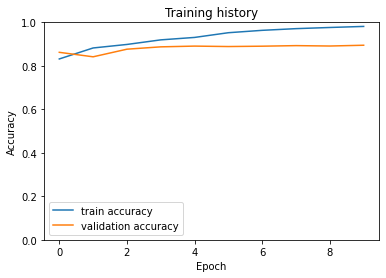

In [36]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [37]:
# Evaluation
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8932

<h1>9) Results</h1>

**Validation accuracy ~89.5%, Test accuracy 89.3%**